In [1]:
#import packages
%matplotlib inline
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline as US
import scipy.integrate as s_int
import time

RK 4th Order, Fixed Timestep
-

In [3]:
#set constants
G=4*(np.pi)**2 #AU^3/yr^2 Msun
M=1 #Msun
a=1 #AU

In [4]:
#define equations
def acceleration(r):
    #get the magnitude of the position
    r_mag=np.linalg.norm(r) #where is x,y
    return (-G*M*r)/(r_mag)**3 #eq 2

def rk_4th_order(r, v, h):
    #first two directly from given eqs
    k1_r=v #from eq 1
    k1_v=acceleration(r) #from eq 2
    
    #rest of the the k's 
    k2_r=v+(0.5*h*k1_v)
    k2_v=acceleration(r+0.5*h*k1_r)
    k3_r=v+(0.5*h*k2_v)
    k3_v=acceleration(r+0.5*h*k2_r)
    k4_r=v+(h*k3_v)
    k4_v=acceleration(r+h*k3_r)
    
    #updated r and v
    r_update=r+(h/6)*(k1_r+2*k2_r+2*k3_r+k4_r)
    v_update=v+(h/6)*(k1_v+2*k2_v+2*k3_v+k4_v)

    return r_update, v_update

In [5]:
#define orbit and integrate via rk4
def orbit(e, h, period=1): #peroid in yrs
    #pericenter and velocity at pericenter
    rp=a*(1-e) #eq 3
    vp=np.sqrt((G*M)/a)*np.sqrt((1+e)/(1-e)) #eg 4

    #number of steps
    steps=int(period/h)

    #initialize positions and energies
    positions=np.zeros((steps,2))
    energies=np.zeros(steps)         
    
    #initial position and velocity
    r=np.array([0,rp])
    v=np.array([-vp,0])

    for i in range(steps):
        positions[i]=r
        #norm for velocity as both x and y components
        energies[i]=(0.5*np.linalg.norm(v)**2)-(G*M/np.linalg.norm(r)) 
        r,v=rk_4th_order(r, v, h)

    return positions, energies

Circular Orbit
-

In [11]:
#set timesteps, use float64 to be precise
t_steps=[np.float64(1/12), np.float64(1/48), np.float64(1/365.25)]

#set lists to store circular orbit errors
circ_pos_errs=[]
circ_energy_errs=[]

#calculate errors for circular orbit
for h in t_steps:
    positions, energies=orbit(e=0, h=h)
    
    #use norm for position error bc x and y components
    position_err=np.linalg.norm(positions[-1]-positions[0])
    energy_err=np.abs(energies[-1]-energies[0])
    
    #append errors
    circ_pos_errs.append(position_err)
    circ_energy_errs.append(energy_err)

for i, h in enumerate(t_steps):
    print(f'Timestep: {h: .4f} yr') #lots of float places...5 was not enough
    print(f'Position Error: {circ_pos_errs[i]: .4e}')
    print(f'Energy Error: {circ_energy_errs[i]: .4e}')


Timestep:  0.0833 yr
Position Error:  4.7933e-01
Energy Error:  1.3637e-01
Timestep:  0.0208 yr
Position Error:  1.3073e-01
Energy Error:  1.3010e-04
Timestep:  0.0027 yr
Position Error:  2.1503e-02
Energy Error:  5.1724e-09


Elliptic Orbit
-

In [14]:
#set lists to store elliptic orbit errors
ell_pos_errs=[]
ell_energy_errs=[]

#calculate errors for elliptic orbit
for h in t_steps:
    positions, energies=orbit(e=0.96, h=h)
    
    #use norm for position error bc x and y components
    position_err=np.linalg.norm(positions[-1]-positions[0])
    energy_err=np.abs(energies[-1]-energies[0])
    
    #append errors
    ell_pos_errs.append(position_err)
    ell_energy_errs.append(energy_err)

for i, h in enumerate(t_steps):
    print(f'Timestep: {h: .4f} yr')
    print(f'Position Error: {ell_pos_errs[i]: .4e}')
    print(f'Energy Error: {ell_energy_errs[i]: .4e}')

Timestep:  0.0833 yr
Position Error:  3.1668e+02
Energy Error:  5.9692e+04
Timestep:  0.0208 yr
Position Error:  9.3540e+01
Energy Error:  4.5800e+03
Timestep:  0.0027 yr
Position Error:  1.2249e+01
Energy Error:  8.2701e+01


Question Answers:
-
The error on final position increases for larger timesteps, as does the error on energy.

Changing the ellipticity greatly increases the errors, but they follow the same trend.

Adaptive Timesteps
-

In [19]:
def adaptive_rk_4th_order(r, v, h, e_goal):
    #fixed timestep
    r1, v1=rk_4th_order(r, v, h)
    
    #two half steps
    r_half1, v_half1=rk_4th_order(r, v, h/2)
    r_half2, v_half2=rk_4th_order(r_half1, v_half1, h/2)

    #relative error
    err_rel=np.abs(1-(np.linalg.norm(r1)/np.linalg.norm(r_half2)))

    #timestep estimate, have been using h so will keep using
    h_est=h*(e_goal/err_rel)**(1/5)

    if err_rel<=e_goal:
         return r_half2, v_half2, h_est
    else:
        return adaptive_rk_4th_order(r, v, h_est, e_goal)  

In [21]:
def adaptive_orbit(e, h, period, e_goal):
    #pericenter and velocity at pericenter
    rp=a*(1-e) #eq 3
    vp=np.sqrt((G*M)/a)*np.sqrt((1+e)/(1-e)) #eg 4

    #lists to store positions, timesteps, and energies
    positions=[]
    timesteps=[]
    energies=[]
    
    #initial position and velocity
    r=np.array([0,rp])
    v=np.array([-vp,0])

    #initial time
    t=0

    #initial timestep is h
    h=h

    while t<period:
        positions.append(r)
        energies.append((0.5*np.linalg.norm(v)**2)-(G*M/np.linalg.norm(r)) )
        timesteps.append(h)
        
        #adaptive rk4, update time
        r, v, h=adaptive_rk_4th_order(r, v, h, e_goal)
        t+=h

    return np.array(positions), np.array(timesteps), np.array(energies)

In [23]:
#conditions
h=np.float64(1/12)
e_goal=10**-5
period=1.205 #wouldn't complete orbit with 1 so increased slightly, because 1yr is period for circular orbit
e=0.96

Total timesteps for 1 orbit: 58


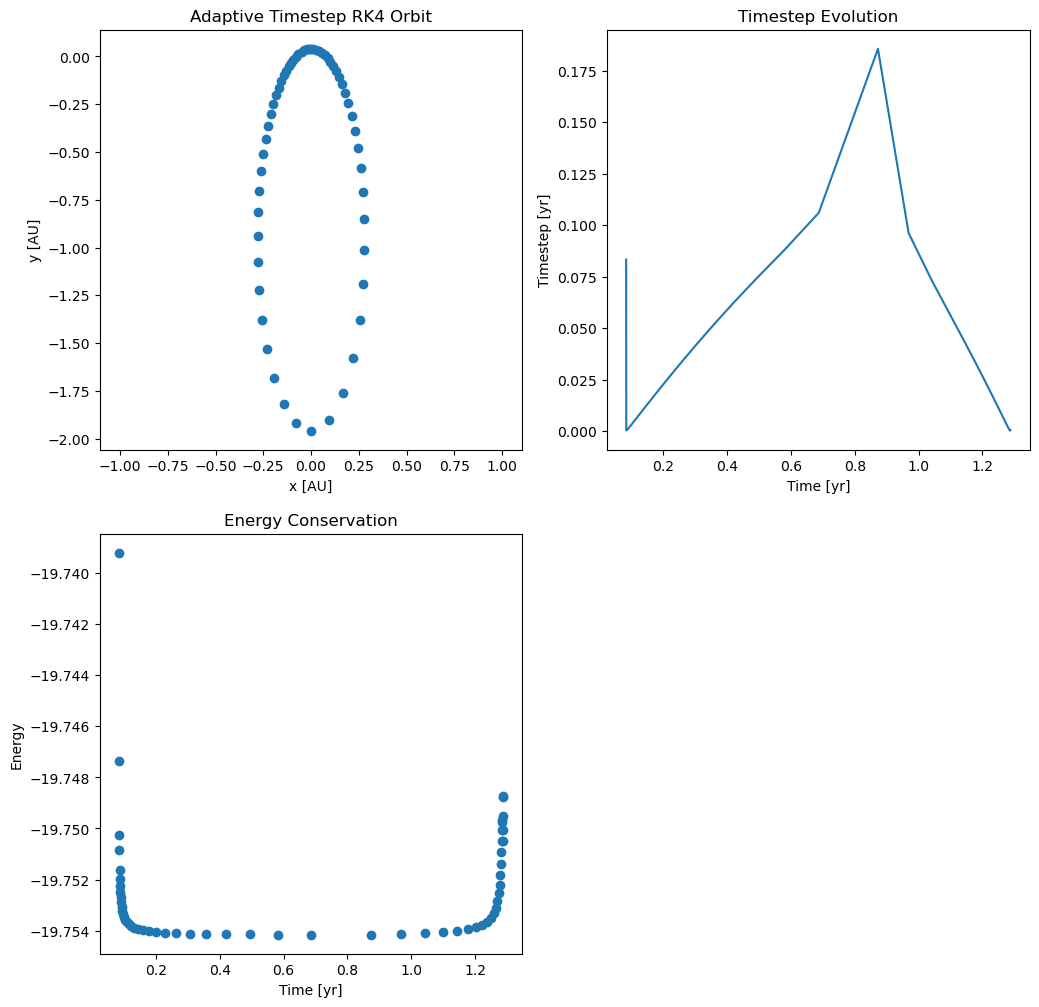

In [25]:
positions, timesteps, energies=adaptive_orbit(e, h, period, e_goal)

#plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)

#axes for different plots
ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1]) 
ax3 = fig.add_subplot(gs[1, 0]) 

ax1.scatter(positions[:,0], positions[:, 1])
ax1.set_xlabel('x [AU]')
ax1.set_ylabel('y [AU]')
ax1.set_title('Adaptive Timestep RK4 Orbit')
ax1.axis('equal')

ax2.plot(np.cumsum(timesteps), timesteps)
ax2.set_xlabel('Time [yr]')
ax2.set_ylabel('Timestep [yr]')
ax2.set_title('Timestep Evolution')

ax3.scatter(np.cumsum(timesteps), energies)
ax3.set_xlabel('Time [yr]')
ax3.set_ylabel('Energy')
ax3.set_title('Energy Conservation')

print(f"Total timesteps for 1 orbit: {len(timesteps)}")


Total timesteps foruestion  25 orbits: 1379


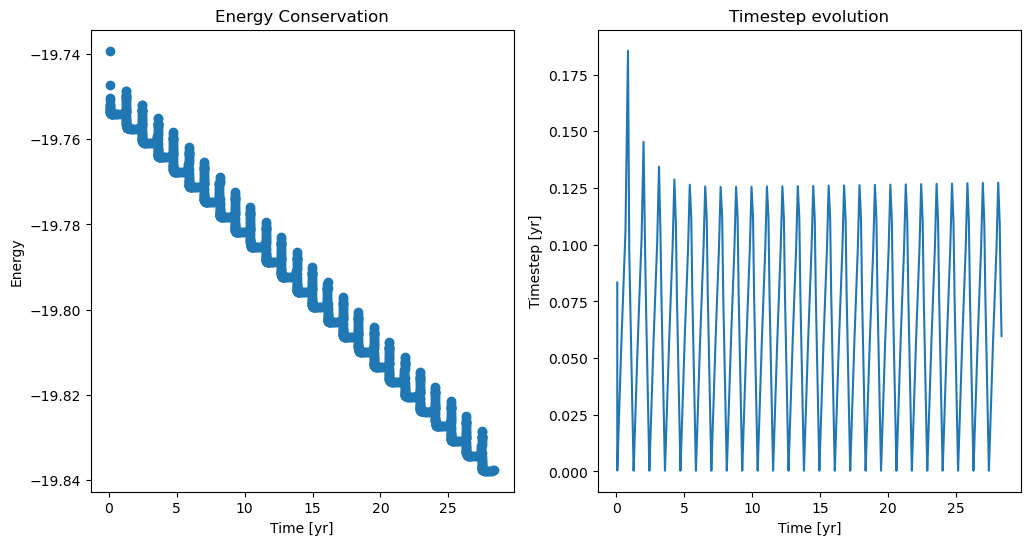

In [27]:
#now for 25
period=28.3 #again change time slightly to make 25 full orbits
positions, timesteps, energies=adaptive_orbit(e, h, period, e_goal)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2)

#axes for different plots
ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1]) 

ax1.scatter(np.cumsum(timesteps), energies)
ax1.set_xlabel('Time [yr]')
ax1.set_ylabel('Energy')
ax1.set_title('Energy Conservation')

ax2.plot(np.cumsum(timesteps), timesteps)
ax2.set_xlabel('Time [yr]')
ax2.set_ylabel('Timestep [yr]')
ax2.set_title('Timestep evolution')

print(f"Total timesteps foruestion  25 orbits: {len(timesteps)}")


Question Answers:
-
Needed 58 timesteps for 1 orbit. Although there are very small fluctuations in energy at the closest approach due to errors from higher velocities, the energy is mostly constant and well conserved.

The energy drifts with time (it appears to do so systematically), decreasing due to the errors accumulating and losing energy over time. This would not be a good approach for planetary orbit calculations over the age of the Solar System due to the accumulation of errors.